<a href="https://colab.research.google.com/github/shizoda/education/blob/main/image/PixelsInImage.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

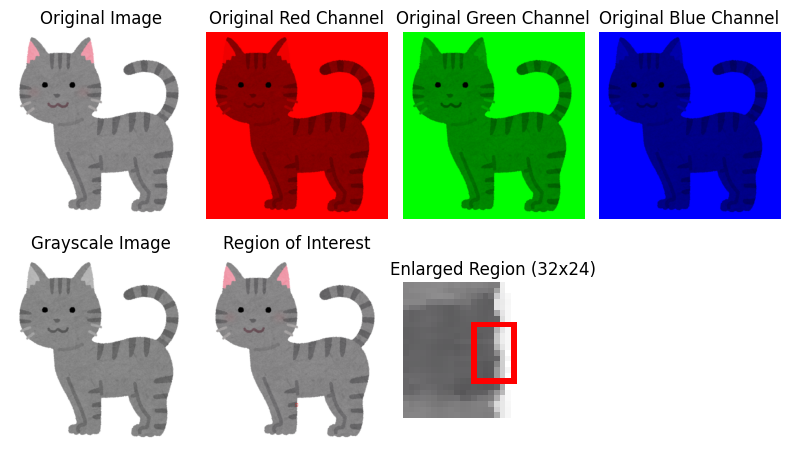

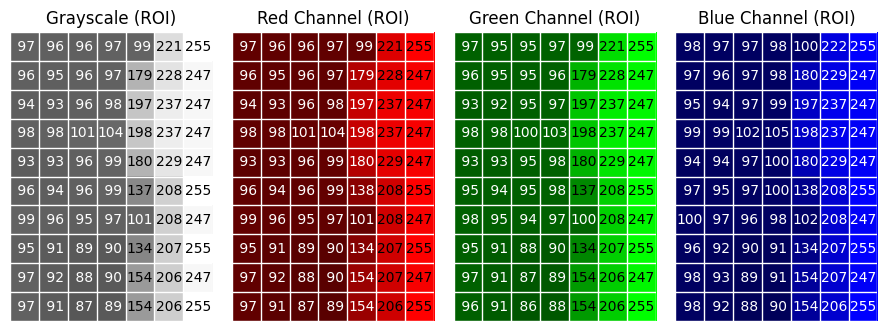

In [6]:
#@title {run: "auto"}
url = "https://raw.githubusercontent.com/shizoda/education/refs/heads/main/sample/irasutoya-cat.png" # @param {"type":"string"}
# Origin of sample data: https://www.irasutoya.com/2018/12/blog-post_505.html
# 透明部分は白に置き換えています

# @title
import cv2
import numpy as np
import matplotlib.pyplot as plt
import requests
from matplotlib.colors import LinearSegmentedColormap

# 画像のダウンロード
image_path = "/tmp/downloaded_image.png"  # 保存先パス, update extension for png

response = requests.get(url)
if response.status_code == 200:
    with open(image_path, 'wb') as f:
        f.write(response.content)
else:
    print(f"画像のダウンロードに失敗しました。ステータスコード: {response.status_code}")
    exit()

# 画像の読み込み
image = cv2.imread(image_path)  # ダウンロードした画像を読み込む
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# アルファチャンネルがある場合、透明部分を白に変換
if image.shape[2] == 4:
    alpha_channel = image[:,:,3]
    # アルファチャンネルが0（完全に透明）のピクセルを白に設定
    image[alpha_channel == 0] = [255, 255, 255, 0] # RGBを255に設定し、アルファはそのまま（BGRなので順番に注意）

# BGRからRGBに変換 (アルファチャンネルがある場合はRGBのみ抽出)
if image.shape[2] == 4:
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGRA2RGB)
else:
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)


# グレースケール変換
gray = cv2.cvtColor(image_rgb, cv2.COLOR_RGB2GRAY)


# 明るいところと暗いところを両方含む 10x7 画素を探す (簡易的な方法)
# 10x7の領域を走査し、その領域内のピクセル値の最大値と最小値の差が大きい場所を探します。
# ここでは探索範囲を限定しています。実際の画像全体を走査することも可能です。
best_x, best_y = -1, -1
max_diff = 0
region_w, region_h = 7,10

# 画像の端で領域がはみ出さないように探索範囲を調整
scan_width = image.shape[1] - region_w
scan_height = image.shape[0] - region_h

if scan_width < 0 or scan_height < 0:
    print("画像サイズが小さすぎます。")
    exit()

for y in range(scan_height):
    for x in range(scan_width):
        roi = gray[y:y+region_h, x:x+region_w]
        diff = np.max(roi) - np.min(roi)
        if diff > max_diff:
            max_diff = diff
            best_x, best_y = x, y

if best_x == -1:
    print("適切な領域が見つかりませんでした。")
    exit()

# 見つかった領域を矩形で囲む
image_with_rect = image_rgb.copy()
cv2.rectangle(image_with_rect, (best_x, best_y), (best_x + region_w, best_y + region_h), (255, 0, 0), 1) # 赤色の矩形

# 拡大する部分の座標（見つかった 10x7 ピクセルの範囲）
x, y, w, h = best_x, best_y, region_w, region_h
roi_gray = gray[y:y+h, x:x+w]
roi_r = image_rgb[y:y+h, x:x+w, 0]
roi_g = image_rgb[y:y+h, x:x+w, 1]
roi_b = image_rgb[y:y+h, x:x+w, 2]

# カスタムカラーマップを定義
cdict_red = {'red':   ((0.0, 0.0, 0.0),
                   (1.0, 1.0, 1.0)),
         'green': ((0.0, 0.0, 0.0),
                   (1.0, 0.0, 0.0)),
         'blue':  ((0.0, 0.0, 0.0),
                   (1.0, 0.0, 0.0))}

Red_cmap = LinearSegmentedColormap('Red_cmap', segmentdata=cdict_red, N=256)

cdict_green = {'red':   ((0.0, 0.0, 0.0),
                   (1.0, 0.0, 0.0)),
         'green': ((0.0, 0.0, 0.0),
                   (1.0, 1.0, 1.0)),
         'blue':  ((0.0, 0.0, 0.0),
                   (1.0, 0.0, 0.0))}

Green_cmap = LinearSegmentedColormap('Green_cmap', segmentdata=cdict_green, N=256)

cdict_blue = {'red':   ((0.0, 0.0, 0.0),
                   (1.0, 0.0, 0.0)),
         'green': ((0.0, 0.0, 0.0),
                   (1.0, 0.0, 0.0)),
         'blue':  ((0.0, 0.0, 0.0),
                   (1.0, 1.0, 1.0))}

Blue_cmap = LinearSegmentedColormap('Blue_cmap', segmentdata=cdict_blue, N=256)


# ピクセル値を文字として表示し、格子を描画する汎用関数
def show_channel_with_grid_and_values(ax, data, title, cmap='gray', vmin=0, vmax=255):
    ax.imshow(data, cmap=cmap, vmin=vmin, vmax=vmax)
    ax.set_title(title)
    ax.axis("off")
    # 格子を描画
    for i in range(data.shape[0] + 1):
        ax.axhline(i - 0.5, color='white', lw=1)
    for j in range(data.shape[1] + 1):
        ax.axvline(j - 0.5, color='white', lw=1)

    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            # テキストの色を濃度値に応じて変更
            if "Red Channel" in title:
                text_color = "white" if data[i, j] <= 200 else "black"
            elif "Blue Channel" in title:
                text_color = "white"
            else: # Grayscale and Green Channel
                text_color = "white" if data[i, j] < 128 else "black"

            # フォントサイズを大きく調整
            ax.text(j, i, f"{data[i, j]:3}", ha="center", va="center", color=text_color, fontsize=10) # Adjust fontsize here


# 新しいプロットレイアウト
fig = plt.figure(figsize=(8, 7)) # 全体のフィギュアサイズを調整

# 元画像とグレースケール画像のサブプロット
ax1 = fig.add_subplot(3, 4, 1)
ax1.imshow(image_rgb)
ax1.set_title("Original Image")
ax1.axis("off")


# 元画像の R, G, B チャンネルのサブプロット
ax4 = fig.add_subplot(3, 4, 2)
ax4.imshow(image_rgb[:,:,0], cmap=Red_cmap)
ax4.set_title("Original Red Channel")
ax4.axis("off")

ax5 = fig.add_subplot(3, 4, 3)
ax5.imshow(image_rgb[:,:,1], cmap=Green_cmap)
ax5.set_title("Original Green Channel")
ax5.axis("off")

ax6 = fig.add_subplot(3, 4, 4)
ax6.imshow(image_rgb[:,:,2], cmap=Blue_cmap)
ax6.set_title("Original Blue Channel")
ax6.axis("off")


ax2 = fig.add_subplot(3, 4, 5)
ax2.imshow(gray, cmap='gray')
ax2.set_title("Grayscale Image")
ax2.axis("off")

ax3 = fig.add_subplot(3, 4, 6)
ax3.imshow(image_with_rect, cmap='gray')
ax3.set_title("Region of Interest")
ax3.axis("off")

# 拡大している領域の周囲 32x24 画素を切り出し表示
enlarged_w, enlarged_h = 32, 24
enlarged_x = max(0, best_x - (enlarged_w - region_w) // 2)
enlarged_y = max(0, best_y - (enlarged_h - region_h) // 2)
enlarged_x2 = min(image.shape[1], enlarged_x + enlarged_w)
enlarged_y2 = min(image.shape[0], enlarged_y + enlarged_h)

roi_enlarged = image_with_rect[enlarged_y:enlarged_y2, enlarged_x:enlarged_x2]

ax7 = fig.add_subplot(3, 4, 7)
ax7.imshow(roi_enlarged)
ax7.set_title(f"Enlarged Region ({enlarged_w}x{enlarged_h})")
ax7.axis("off")

plt.tight_layout()
plt.show()

# 10x7領域のチャンネル表示プロット
fig, axes = plt.subplots(1, 4, figsize=(9, 4))
show_channel_with_grid_and_values(axes[3], roi_b, "Blue Channel (ROI)", cmap=Blue_cmap) # 青色のグラデーションと格子・値
show_channel_with_grid_and_values(axes[2], roi_g, "Green Channel (ROI)", cmap=Green_cmap) # 緑色のグラデーションと格子・値
show_channel_with_grid_and_values(axes[1], roi_r, "Red Channel (ROI)", cmap=Red_cmap) # 赤チャンネルは専用の関数を使用
show_channel_with_grid_and_values(axes[0], roi_gray, "Grayscale (ROI)") # グレースケールも汎用関数を使用


plt.tight_layout()
plt.show()